# Инициализация

Описание: 
В Яндекс Музыке более 70 млн треков. Взаимодействие с музыкальным сервисом должно быть удобным, простым и приятным. Для этого пользователю нужно предлагать треки или подборки, основываясь на его вкусах и предпочтениях.
Бизнес-задача: Облегчить пользовательский опыт, создав систему персональных рекомендаций.

Загружаем библиотеки необходимые для выполнения кода ноутбука.

In [3]:
import logging
import memory_profiler
import matplotlib.pyplot as plt
import numpy as np # type: ignore
import pandas as pd

import pickle
import joblib

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
%config InlineBackend.figure_format = 'retina'

# === ЭТАП 1 ===

# Загрузка первичных данных

Загружаем первичные данные из файлов:
- tracks.parquet
- catalog_names.parquet
- interactions.parquet

In [5]:
#данные о треках
tracks = pd.read_parquet("./tracks.parquet")
#имена артистов, названия альбомов, треков и жанров 
catalog = pd.read_parquet("./catalog_names.parquet")
#данные о том, какие пользователи прослушали трек
interactions = pd.read_parquet("./interactions.parquet")

# Обзор данных

Проверяем данные, есть ли с ними явные проблемы.

In [5]:
tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   track_id  1000000 non-null  int64 
 1   albums    1000000 non-null  object
 2   artists   1000000 non-null  object
 3   genres    1000000 non-null  object
dtypes: int64(1), object(3)
memory usage: 30.5+ MB


In [6]:
tracks.sample(5).T

,843149,813220,167165,448498,495650
track_id,67751203,64025415,4364431,31308274,34221447
albums,"[11161279, 12091735]",[10239529],"[495194, 523370]",[3793554],[61521]
artists,"[637979, 2356023]","[7625508, 6885650]","[422735, 314361]","[150722, 3298171, 3768644]",[164408]
genres,[11],[16],"[44, 75]",[16],"[3, 75]"


In [7]:
catalog.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1812471 entries, 0 to 1812470
Data columns (total 3 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   id      int64 
 1   type    object
 2   name    object
dtypes: int64(1), object(2)
memory usage: 41.5+ MB


In [8]:
catalog.sample(5).T

,1766993,774095,1749239,174335,1005904
id,86442450,6159778,82045939,2811105,6341391
type,track,artist,track,album,track
name,They Speak (Ow),k1k1,Rome Total War,Deep Zen Meditation,Sway


In [9]:
catalog.id.nunique()

1776697

In [10]:
interactions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 222629898 entries, 0 to 291
Data columns (total 4 columns):
 #   Column      Dtype         
---  ------      -----         
 0   user_id     int32         
 1   track_id    int32         
 2   track_seq   int16         
 3   started_at  datetime64[ns]
dtypes: datetime64[ns](1), int16(1), int32(2)
memory usage: 5.4 GB


In [11]:
interactions.sample(5).T

,802,690,301,394,349
user_id,567600,936638,1128086,143906,527698
track_id,78085045,26398023,37874820,38917102,62100197
track_seq,803,691,302,395,350
started_at,2022-10-27 00:00:00,2022-08-28 00:00:00,2022-11-10 00:00:00,2022-08-11 00:00:00,2022-07-13 00:00:00


In [12]:
interactions.track_id.nunique()

1000000

In [13]:
interactions.user_id.nunique()

1373221

In [14]:
#создаем рейтинг на основе номера трека в истории пользователя
interactions["rating"] = interactions["track_seq"].rank(method='dense', ascending=False).astype("int")

In [15]:
interactions.nlargest(10, 'rating')

,user_id,track_id,track_seq,started_at,rating
0,0,99262,1,2022-07-17,16637
0,1,24417,1,2022-06-11,16637
0,2,264937,1,2022-04-15,16637
0,3,6006252,1,2022-02-05,16637
0,4,966,1,2022-03-29,16637
0,5,975,1,2022-05-12,16637
0,6,17309,1,2022-07-16,16637
0,7,89484,1,2022-04-07,16637
0,8,10867987,1,2022-02-06,16637
0,9,1197558,1,2022-11-22,16637


# Выводы

Приведём выводы по первому знакомству с данными:
- есть ли с данными явные проблемы,
- какие корректирующие действия (в целом) были предприняты.

Данные имеют правильный тип. Пропусков нет. Уникальных треков 1000000, пользователей 1373221. По номеру трека в истории пользователя, создаем рейтинг трека

# === ЭТАП 2 ===

# EDA

Распределение количества прослушанных треков.

In [6]:
#группируем по дате прослушивания: количество пользователей и прослушанных треков
date_track = interactions.groupby("started_at").agg(user=("user_id", "nunique"), track_nunique=("track_id", "nunique"), track_count=("track_id", "count"))
date_track

,user,track_nunique,track_count
started_at,,,
2022-01-01,5835,4767,35487
2022-01-02,7165,6524,37053
2022-01-03,8357,7871,39895
2022-01-04,9403,9271,43047
2022-01-05,10861,10429,46365
...,...,...,...
2022-12-27,266882,159038,806317
2022-12-28,247031,147529,735637
2022-12-29,223515,131721,641531


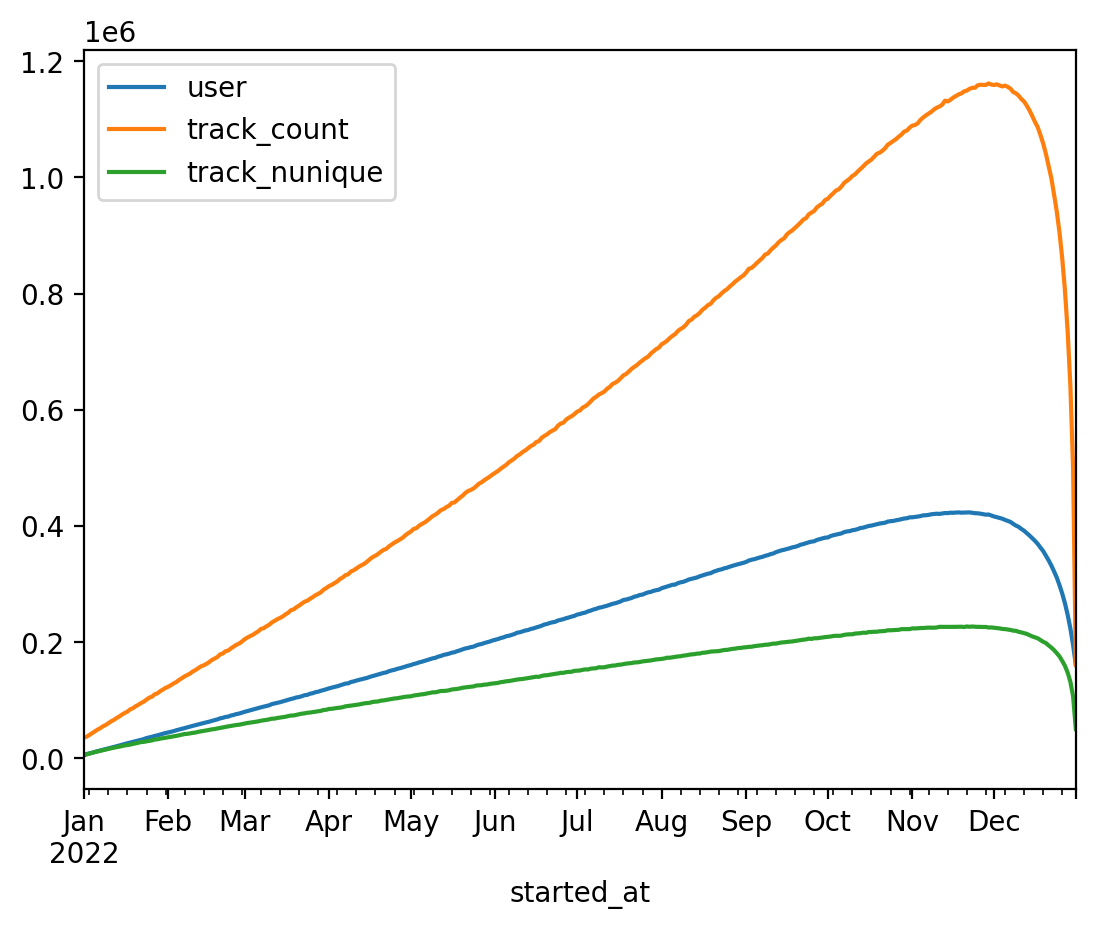

In [5]:
date_track[['user', 'track_count', 'track_nunique']].plot();

Вывод: В начале года музыку слушают меньше, в течении года растет, пик по количеству прослушанных треков и количеству пользователей приходится на ноябрь-декабрь, 31 декабря резко падает. К концу года больше пользователей слушают одинаковую музыку.

In [6]:
#группируем по пользователям: количество, прослушанных уникальных треков
user_gr = interactions.groupby("user_id").agg(track=("track_id", "nunique")).sort_values(by='track', ascending=False).reset_index()
user_gr

,track
user_id,
398979,16637
1200889,15392
590868,15136
731216,13223
339714,12768
...,...
1330396,1
1330365,1
258536,1


In [43]:
#оставляем выборку из пользователей, которые прослушали не менее 2000 треков, выведем характеристики
us = user_gr.query("track>2000")
us.describe()

,track
count,8198.000000
mean,3177.654428
std,1463.748493
min,2001.000000
25%,2259.250000
50%,2656.000000
75%,3490.000000
max,16637.000000


Наиболее популярные треки

In [6]:
#группируем по трекам: сколько пользователей их прослушало
track_pop = interactions.groupby("track_id").agg(user=("user_id", "nunique")).sort_values(by="user", ascending=False)
track_pop

,user
track_id,
53404,111062
33311009,106921
178529,101924
35505245,99490
65851540,86670
...,...
44207632,5
44204233,5
44203558,5


In [21]:
#возьмем треки, прослушанные более 5000 раз
tr = track_pop.query('user > 5000')
#посмотрим статистику данной выборки
tr.describe()

Наиболее популярные жанры

In [43]:
#составим список жанров
list = []
for row in tracks["genres"]:
    for genre in row:
        list.append(genre)

#посчитаем сколько раз повторяется
from collections import defaultdict
counter = defaultdict(int)
for elem in list:
    counter[elem] += 1

#отсортируем по убыванию
genre = sorted(counter.items(), key=lambda item: item[1], reverse=True)


In [44]:
#переводим в датафрейм
genre = pd.DataFrame(genre)
#переименовавываем смтолбцы
genre = genre.rename(columns={0: "id", 1: "genre_count"})
#соедняем с названиями
popular_genre = genre.merge(catalog[["name", "id"]], on = "id", how = "left")
#удаляем дубликаты индексов артистов
popular_genre.drop_duplicates(subset="id", keep='last', inplace=True)
popular_genre.reset_index(drop=True, inplace=True)
#оставляем 30 самых популярных
pop_genre = popular_genre.head(30)
pop_genre

,id,genre_count,name
0,11,166285,pop
1,75,128212,rap
2,102,118509,allrock
3,68,114245,electronics
4,47,72311,metal
5,3,65958,rusrap
6,44,59778,foreignrap
7,14,55177,rock
8,16,51631,dance
9,20,46707,ruspop


In [45]:
#pop_genre.to_parquet("pop_genre.parquet")

Треки, которые никто не прослушал

In [7]:
#отсортируем группировку по трекам по возрастанию
track_min = track_pop.sort_values(by="user")

In [8]:
#треки, которые прослушало меньше 20 пользователей
track_min.query("user < 20")

,user
track_id,
34550746,5
2374525,5
2374732,5
2374764,5
2375512,5
...,...
6914775,19
42774868,19
61228397,19


# Преобразование данных

Преобразуем данные в формат, более пригодный для дальнейшего использования в расчётах рекомендаций.

Соединяем данные о музыкальных треках:

In [27]:
#соединяем таблицы tracks и catalog по track_id, из catalog берем данные о треках. 
items = tracks.merge(catalog, left_on = "track_id", right_on="id", how="inner")
items = items.drop(columns="id")
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025340 entries, 0 to 1025339
Data columns (total 6 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   track_id  1025340 non-null  int64 
 1   albums    1025340 non-null  object
 2   artists   1025340 non-null  object
 3   genres    1025340 non-null  object
 4   type      1025340 non-null  object
 5   name      1025340 non-null  object
dtypes: int64(1), object(5)
memory usage: 46.9+ MB


In [12]:
#переменуем названия столбцов 
interactions = interactions.rename(columns={"track_id": "item_id"})
items = items.rename(columns={"track_id": "item_id"})

Interactions разобьем на периоды для анализа

In [13]:
interactions_1  = interactions.query("started_at < '2022-12-16'")

In [14]:
interactions_2 = interactions.query("started_at >= '2022-12-16'")

In [15]:
#уникальные пользователи в обоих выборках
users_1 = interactions_1["user_id"].drop_duplicates()
users_2 = interactions_2["user_id"].drop_duplicates()
print(len(users_1), len(users_2))

1342566 783525


In [16]:
#пользователи, которые есть только в первой выборке
users_not_2 = set(users_1) - set(users_2)
len(users_not_2)

589696

In [17]:
#группируем по пользователям, которые есть только в первой выборке, количество прослушанных треков.
users_int = interactions_1.query("user_id in @users_not_2").groupby('user_id').agg(item=("item_id", "nunique")).sort_values(by="item").reset_index()
users_int

,user_id,item
0,916518,1
1,1297777,1
2,1005518,1
3,1282429,1
4,1284891,1
...,...,...
589691,821048,3264
589692,453931,3280
589693,288223,3346
589694,985024,3356


In [18]:
#пользователи, прослушавшие меньше 500 треков
users_min = users_int.query('item < 500')
users_id = users_min['user_id']
len(users_id)


554107

In [19]:
#уникальные треки в каждой выборке
track_1 = interactions_1["item_id"].drop_duplicates()
track_2 = interactions_2["item_id"].drop_duplicates()
print(len(track_1), len(track_2))

999695 594326


In [20]:
#треки, которые есть только в первой выборке
track_not_2 = set(track_1) - set(track_2)
len(track_not_2)

405674

In [21]:
#группируем по трекам, которые есть только в первой выборке, количество прослушавших их пользователей
int_track = interactions_1.query("item_id in @track_not_2").groupby('item_id').agg(user=("user_id", "nunique")).sort_values(by="user").reset_index()
int_track

,item_id,user
0,26,5
1,17979443,5
2,17983591,5
3,17983650,5
4,17986692,5
...,...,...
405669,86213,1395
405670,293807,1634
405671,681582,1682
405672,576964,1742


In [22]:
#треки, которые прослушали меньше 500 раз
track_int_min = int_track.query('user < 500')
track_id = track_int_min['item_id']
len(track_id)

405223

In [23]:
#удаляем неактивных пользователей и треки, которые мало слушают из обучающей выборки.
events = interactions.query("item_id not in @track_id and user_id not in @users_id")
events

,user_id,item_id,track_seq,started_at,rating
0,3,6006252,1,2022-02-05,16637
1,3,21642261,2,2022-02-10,16636
2,3,21642265,3,2022-02-17,16635
3,3,24692821,4,2022-03-02,16634
4,3,25995209,5,2022-03-13,16633
...,...,...,...,...,...
287,1374582,95514767,288,2022-12-29,16350
288,1374582,97220301,289,2022-12-29,16349
289,1374582,97241171,290,2022-12-29,16348
290,1374582,98542641,291,2022-12-29,16347


# Сохранение данных

Сохраним данные в двух файлах в персональном S3-бакете по пути `recsys/data/`:
- `items.parquet` — все данные о музыкальных треках,
- `events.parquet` — все данные о взаимодействиях.

In [ ]:
#items.to_parquet("items.parquet")
#events.to_parquet("events.parquet")

In [11]:
#import mlflow
#import os
#import boto3

#TRACKING_SERVER_HOST = "127.0.0.1"
#TRACKING_SERVER_PORT = 5000

/home/lesya/.local/lib/python3.10/site-packages/pydantic/_internal/_config.py:345: UserWarning: Valid config keys have changed in V2:
* 'schema_extra' has been renamed to 'json_schema_extra'
  warnings.warn(message, UserWarning)


In [12]:
#mlflow.set_tracking_uri(f"http://127.0.0.1:5000")
#mlflow.set_registry_uri(f"http://127.0.0.1:5000") 

In [14]:
EXPERIMENT_NAME = "rec_sistem"

In [70]:
#RUN_NAME = "info"

#experiment_id = mlflow.create_experiment(EXPERIMENT_NAME) 

#experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

#with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
 #   run_id = run.info.run_id
  #  mlflow.log_artifact('./events.parquet', artifact_path='recsys/data')
   # mlflow.log_artifact('./items.parquet', artifact_path='recsys/data')

# Очистка памяти

Здесь, может понадобится очистка памяти для высвобождения ресурсов для выполнения кода ниже. 

Приведите соответствующие код, комментарии, например:
- код для удаление более ненужных переменных,
- комментарий, что следует перезапустить kernel, выполнить такие-то начальные секции и продолжить с этапа 3.

In [25]:
#Удаляем ненужные переменные 
del interactions
del interactions_1
del interactions_2
del catalog
del tracks 


In [ ]:
#удаляем переменные, если загружаем их заново
del items
del events

In [ ]:
#удаляем после выполнения EDA
del int_track
del users_int
del track_min
del track_pop
del user_gr
del date_track
del popular_genre

# === ЭТАП 3 ===

# Загрузка данных

Если необходимо, то загружаем items.parquet, events.parquet.

In [31]:
items = pd.read_parquet("./items.parquet")

In [5]:
#items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025340 entries, 0 to 1025339
Data columns (total 6 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   item_id  1025340 non-null  int64 
 1   albums   1025340 non-null  object
 2   artists  1025340 non-null  object
 3   genres   1025340 non-null  object
 4   type     1025340 non-null  object
 5   name     1025340 non-null  object
dtypes: int64(1), object(5)
memory usage: 46.9+ MB


In [32]:
events = pd.read_parquet("./events.parquet")

In [20]:
#events.info()

<class 'pandas.core.frame.DataFrame'>
Index: 165770196 entries, 0 to 291
Data columns (total 5 columns):
 #   Column      Dtype         
---  ------      -----         
 0   user_id     int32         
 1   item_id     int32         
 2   track_seq   int16         
 3   started_at  datetime64[ns]
 4   rating      int64         
dtypes: datetime64[ns](1), int16(1), int32(2), int64(1)
memory usage: 5.2 GB


# Разбиение данных

Разбиваем данные на тренировочную, тестовую выборки.

In [4]:
#обучающая выборка
events_train = events.query("started_at < '2022-12-16'")

In [5]:
#меньшая выборка, для экономии ресурсов, для сопоставления с пользователями похожих рекомендаций    
events_sim = events_train.query("started_at > '2022-12-08'")

In [6]:
#тестовая выборка
events_test = events.query("started_at >= '2022-12-16'")
events_test.started_at.sort_values()

11     2022-12-16
2973   2022-12-16
2123   2022-12-16
2122   2022-12-16
744    2022-12-16
          ...    
115    2022-12-31
41     2022-12-31
16     2022-12-31
153    2022-12-31
165    2022-12-31
Name: started_at, Length: 13898646, dtype: datetime64[ns]

In [8]:
#размер выборок для получения начальных рекомендаций
print(f"train: {events_train.shape}, test: {events_test.shape}")

train: (151871550, 5), test: (13898646, 5)


In [7]:
#для обучения модели ранжирования делим тестовую выборку на 2 части таргет и тест:
events_labels = events_test.query("started_at <= '2022-12-24'")
events_test_2 = events_test.query("started_at > '2022-12-24'")
print(f"target: {events_labels.shape}, test_2: {events_test_2.shape}")

target: (9287827, 5), test_2: (4610819, 5)


In [8]:
#вторая обучающая выборка со сдвигом в будующее(train+labels) для получения новых рекомендаций
events_inference = pd.concat([events_train, events_labels])
print(f"inference: {events_inference.shape}")

inference: (161159377, 5)


In [22]:
#количество пользователей в первоначальных выборках
users_train = events_train["user_id"].drop_duplicates()
users_test = events_test["user_id"].drop_duplicates()
cold_users = set(users_test) - set(users_train)
print(f"Пользователи: train: {len(users_train)}, test: {len(users_test)}, холодные: {len(cold_users)}")

Пользователи: train: 787916, test: 783525, холодные: 31198


In [28]:
#количество пользователей в новых выборках
users_inference = events_inference["user_id"].drop_duplicates()
users_test_2 = events_test_2["user_id"].drop_duplicates()
cold_users_2 = set(users_test_2) - set(users_inference)
print(f"Пользователи: train: {len(users_inference)}, test: {len(users_test_2)},холодные: {len(cold_users_2)}")

Пользователи: train: 526825, test: 534841,холодные: 8016


# Топ популярных

Рассчитаем рекомендации как топ популярных.

In [48]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

Для расчета возьмем последние четыре месяца

In [49]:
#группировка треков по количеству прослушиваний и среднему рейтингу
item_popularity = events_train.query("started_at >= '2022-07-01' ").groupby(["item_id"]).agg(users=("user_id", "nunique"), avg_rating=("rating", "mean")).reset_index()

In [52]:
#нормализация пользователей и среднего рейтинга трека
item_popularity[["users_norm", "avg_rating_norm"]] = scaler.fit_transform(item_popularity[["users", "avg_rating"]])

#выбираем первые 100 треков
item_popularity["popularity_score"] = item_popularity["users_norm"] * item_popularity["avg_rating_norm"]
item_popularity = item_popularity.sort_values(by="popularity_score", ascending=False)
top_100_pop = item_popularity.nlargest(100, "popularity_score")

#добавим к топу информацию о треках
top_100_pop = top_100_pop.merge(items.set_index("item_id")[["genres", "artists", "name"]], on="item_id") 
with pd.option_context('display.max_rows', 20):
    display(top_100_pop[["item_id", "popularity_score", "genres", "artists", "name"]])

,item_id,popularity_score,genres,artists,name
0,33311009,0.980436,"[14, 102]",[675068],Believer
1,35505245,0.851021,"[3, 75]","[4611844, 588511]",I Got Love
2,60292250,0.837690,[74],[611169],Blinding Lights
3,51241318,0.835422,[74],"[1802873, 3135644, 9012818]",In The End
4,65851540,0.792178,"[11, 20]",[1554548],Юность
...,...,...,...,...,...
95,73376988,0.437382,"[11, 20]",[5548288],Ягода малинка
96,62244864,0.434017,"[11, 20]",[4331814],Покинула чат
97,78824202,0.433617,[102],[5458792],I WANNA BE YOUR SLAVE
98,41883693,0.433340,"[11, 20]",[3304163],Малиновый свет


In [23]:
#анализируем взаимодейтвие холодных пользовотелей в тестовой выборке с популярными треками
cold_users_events_with_recs = events_test[events_test["user_id"].isin(cold_users)].merge(top_100_pop, on="item_id", how="left")
#оставляем только тех холодных пользователей, для которых сопоставилсоь среднее значение рейтинга
cold_user_items_no_avg_rating_idx = cold_users_events_with_recs["avg_rating"].isnull()
#сравниваем соответствие рейтинга пользователя и среднего рейтинга
cold_users_rec = cold_users_events_with_recs[~cold_user_items_no_avg_rating_idx][["user_id", "item_id", "rating", "avg_rating", "popularity_score"]]
cold_users_rec.reset_index(drop=True, inplace=True)

In [ ]:
print(f"Холодные пользователи, для котоpых рекомендации соответствуют: {cold_users_rec['user_id'].nunique()}")
cold_users_hit_ratio = cold_users_events_with_recs.groupby("user_id").agg(hits=("avg_rating", lambda x: (~x.isnull()).mean()))
print(f"Доля холодных пользователей без релевантных рекомендаций: {(cold_users_hit_ratio == 0).mean().iat[0]: .2f}")
print(f"Среднее покрытие холодных пользователей рекомендациями: {(cold_users_hit_ratio !=0).mean().iat[0]: .2f}")

In [33]:
#для холодных
top_popular = cold_users_rec[["user_id", "item_id", "popularity_score"]]
#top_popular.to_parquet("top_popular.parquet")

In [24]:
#cold_users_events_with_recs.to_parquet("cold_users_with_recs.parquet")

In [25]:
#по свежей выборке
item_popularity_2 = events_inference.query("started_at >= '2022-08-01' ").groupby(["item_id"]).agg(users=("user_id", "nunique"), avg_rating=("rating", "mean")).reset_index()

In [26]:
item_popularity_2[["users_norm", "avg_rating_norm"]] = scaler.fit_transform(item_popularity_2[["users", "avg_rating"]])

item_popularity_2["popularity_score"] = item_popularity_2["users_norm"] * item_popularity_2["avg_rating_norm"]
item_popularity_2 = item_popularity_2.sort_values(by="popularity_score", ascending=False)
top_100_pop_2 = item_popularity_2.nlargest(100, "popularity_score")

top_100_pop_2 = top_100_pop_2.merge(items.set_index("item_id")[["genres", "artists", "name"]], on="item_id") 
with pd.option_context('display.max_rows', 20):
    display(top_100_pop_2[["item_id", "popularity_score", "genres", "artists", "name"]])

,item_id,popularity_score,genres,artists,name
0,33311009,0.982605,"[14, 102]",[675068],Believer
1,60292250,0.879727,[74],[611169],Blinding Lights
2,65851540,0.867972,"[11, 20]",[1554548],Юность
3,51241318,0.853286,[74],"[1802873, 3135644, 9012818]",In The End
4,35505245,0.850184,"[3, 75]","[4611844, 588511]",I Got Love
...,...,...,...,...,...
95,44209075,0.440574,[16],"[5706302, 4888541]",Freed from Desire
96,694683,0.439362,"[59, 102]",[191175],Highway to Hell
97,732401,0.439183,"[2, 102]",[218099],ИСКАЛА
98,41883693,0.436728,"[11, 20]",[3304163],Малиновый свет


In [29]:
cold_users_events_with_recs_2 = events_test_2[events_test_2["user_id"].isin(cold_users_2)].merge(top_100_pop_2, on="item_id", how="left")
cold_user_items_no_avg_rating_idx_2 = cold_users_events_with_recs_2["avg_rating"].isnull()
cold_users_rec_2 = cold_users_events_with_recs_2[~cold_user_items_no_avg_rating_idx_2][["user_id", "item_id", "rating", "avg_rating", "popularity_score"]]
cold_users_rec_2.reset_index(drop=True, inplace=True)

In [ ]:
print(f"Холодные пользователи, для котоpых рекомендации соответствуют: {cold_users_rec_2['user_id'].nunique()}")
cold_users_hit_ratio = cold_users_events_with_recs_2.groupby("user_id").agg(hits=("avg_rating", lambda x: (~x.isnull()).mean()))
print(f"Доля холодных пользователей без релевантных рекомендаций: {(cold_users_hit_ratio == 0).mean().iat[0]: .2f}")
print(f"Среднее покрытие холодных пользователей рекомендациями: {(cold_users_hit_ratio !=0).mean().iat[0]: .2f}")

In [26]:
#сохраняем рекомендации популярных треков на новой выборке
top_popular_2 = cold_users_rec_2[["user_id", "item_id", "popularity_score"]]
#top_popular_2.to_parquet("top_popular_2.parquet")

In [30]:
#cold_users_events_with_recs_2.to_parquet("cold_users_with_recs_2.parquet")

### Рассчитаем персональные рекомендации.

#### ALS алгоритм

##### 1. Перекодируем идентификаторы пользователей и объектов:

In [11]:
import scipy
import sklearn.preprocessing

# перекодируем индентификаторы пользователей:
user_encoder = sklearn.preprocessing.LabelEncoder()
user_encoder.fit(events["user_id"])

LabelEncoder()

In [12]:
# перекодируем идентификаторы объектов
item_encoder = sklearn.preprocessing.LabelEncoder()
item_encoder.fit(items["item_id"])
items["item_id_enc"] = item_encoder.transform(items["item_id"])

Для первых рекомендаций

In [13]:
events_train["user_id_enc"] = user_encoder.transform(events_train["user_id"])
events_test["user_id_enc"] = user_encoder.transform(events_test["user_id"])

/tmp/ipykernel_5047/4073530557.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_train["user_id_enc"] = user_encoder.transform(events_train["user_id"])
/tmp/ipykernel_5047/4073530557.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_test["user_id_enc"] = user_encoder.transform(events_test["user_id"])


In [14]:
events_train["item_id_enc"] = item_encoder.transform(events_train["item_id"])
events_test["item_id_enc"] = item_encoder.transform(events_test["item_id"])

/tmp/ipykernel_5047/150670037.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_train["item_id_enc"] = item_encoder.transform(events_train["item_id"])
/tmp/ipykernel_5047/150670037.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_test["item_id_enc"] = item_encoder.transform(events_test["item_id"])


Для новых рекомендаций

In [63]:
events_inference["user_id_enc"] = user_encoder.transform(events_inference["user_id"])
events_test_2["user_id_enc"] = user_encoder.transform(events_test_2["user_id"])

/tmp/ipykernel_12187/1072496576.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_test_2["user_id_enc"] = user_encoder.transform(events_test_2["user_id"])


In [62]:
events_inference["item_id_enc"] = item_encoder.transform(events_inference["item_id"])
events_test_2["item_id_enc"] = item_encoder.transform(events_test_2["item_id"])

/tmp/ipykernel_12187/1656603227.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_test_2["item_id_enc"] = item_encoder.transform(events_test_2["item_id"])


##### 2. Создаем sparse-матрицу формата CSR:

In [15]:
#для первой выборки
user_item_matrix_train = scipy.sparse.csr_matrix((events_train["rating"], (events_train["user_id_enc"], events_train["item_id_enc"])), dtype=np.int8)

In [14]:
#размер, полученной матрицы
import sys 
sum([sys.getsizeof(i) for i in user_item_matrix_train.data])/1024**3

3.5360350739210844

In [64]:
# матрица для второй выборки
user_item_matrix_inference = scipy.sparse.csr_matrix((events_inference["rating"], (events_inference["user_id_enc"], events_inference["item_id_enc"])), dtype=np.int8)

In [33]:

import sys 
sum([sys.getsizeof(i) for i in user_item_matrix_inference.data])/1024**3

3.7522841477766633

##### 3.Инициализируем и обучим модели

In [18]:
#1-я модель
from implicit.als import AlternatingLeastSquares

als_model = AlternatingLeastSquares(factors=50, iterations=50, regularization=0.05, random_state=0)
als_model.fit(user_item_matrix_train)

100%|██████████| 50/50 [23:12<00:00, 27.84s/it]


In [19]:
#сохраняем модель
#joblib.dump(als_model, "als_model.joblib")

['als_model.joblib']

In [21]:
#als_model = joblib.load('./als_model.joblib')

/home/lesya/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Персональные рекомендации

In [15]:
#получаем список всех возможных user_id (перекодированных)
user_ids_encoded = range(len(user_encoder.classes_))
user_ids_encoded

range(0, 819114)

In [20]:
#получаем 50 рекомендаций для каждого пользователя 
als_recommendations = als_model.recommend(
    user_ids_encoded,
    user_item_matrix_train[user_ids_encoded],
    filter_already_liked_items=False, N=50)


In [21]:
#преобразуем полученные рекомендации в табличный формат
item_ids_enc = als_recommendations[0]
als_scores = als_recommendations[1]

als_recommendations = pd.DataFrame({
    "user_id_enc": user_ids_encoded,
    "item_id_enc": item_ids_enc.tolist(),
    "score": als_scores.tolist()})

In [22]:
als_recommendations = als_recommendations.explode(["item_id_enc", "score"], ignore_index=True)

In [23]:
#приводим типы данных 
als_recommendations["item_id_enc"] = als_recommendations["item_id_enc"].astype("int")
als_recommendations["score"] = round(als_recommendations["score"].astype("float"), 6)
#получаем изначальные идентификаторы
als_recommendations["user_id"] = user_encoder.inverse_transform(als_recommendations["user_id_enc"])
als_recommendations["item_id"] = item_encoder.inverse_transform(als_recommendations["item_id_enc"])
als_recommendations = als_recommendations.drop(columns=["user_id_enc", "item_id_enc"])

In [92]:
als_recommendations = als_recommendations.query("score > 0")

In [93]:
#сохраняем рекомендации
als_recommendations = als_recommendations[["user_id", "item_id", "score"]]
als_recommendations.to_parquet("personal_als.parquet")

In [65]:
#2-я модель
als_model_2 = AlternatingLeastSquares(factors=50, iterations=30, regularization=0.05, random_state=0)
als_model_2.fit(user_item_matrix_inference)

/home/lesya/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/lesya/.local/lib/python3.10/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 8 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()
100%|██████████| 30/30 [17:03<00:00, 34.13s/it]


In [67]:

#joblib.dump(als_model_2, "als_model_2.joblib")

['als_model_2.joblib']

In [14]:
#als_model_2 = joblib.load('./als_model_2.joblib')

In [15]:
#получаем 50 новых рекомендаций для каждого пользователя 
als_recommendations_2 = als_model_2.recommend(
    user_ids_encoded,
    user_item_matrix_inference[user_ids_encoded],
    filter_already_liked_items=False, N=50)

In [17]:
#преобразуем полученные рекомендации в табличный формат
item_ids_enc = als_recommendations_2[0]
als_scores = als_recommendations_2[1]

als_recommendations_2 = pd.DataFrame({
    "user_id_enc": user_ids_encoded,
    "item_id_enc": item_ids_enc.tolist(),
    "als_score": als_scores.tolist()})

In [19]:
als_recommendations_2 = als_recommendations_2.explode(["item_id_enc", "als_score"], ignore_index=True)

In [45]:
#приводим типы данных 
als_recommendations_2["item_id_enc"] = als_recommendations_2["item_id_enc"].astype("int")
als_recommendations_2["als_score"] = round(als_recommendations_2["als_score"].astype("float"), 6)
#получаем изначальные идентификаторы
als_recommendations_2["user_id"] = user_encoder.inverse_transform(als_recommendations_2["user_id_enc"])
als_recommendations_2["item_id"] = item_encoder.inverse_transform(als_recommendations_2["item_id_enc"])
als_recommendations_2 = als_recommendations_2.drop(columns=["user_id_enc", "item_id_enc"])

In [94]:
als_recommendations_2 = als_recommendations_2.query("score > 0")

In [96]:
#сохраняем новые рекомендации
#als_recommendations_2 = als_recommendations_2[["user_id", "item_id", "score"]]
#als_recommendations_2.to_parquet("personal_als_2.parquet")

# Похожие

Рассчитаем похожие, они позже пригодятся для онлайн-рекомендаций.

In [15]:
#получаем список всех возможных item_id (перекодированных)
item_ids_encoded = range(len(item_encoder.classes_))
item_ids_encoded

range(0, 1000000)

In [25]:
#10 похожих рекомендаций объектов для первой выборки
similar_rec = als_model.similar_items(item_ids_encoded, N=10)

In [28]:
#преобразуем полученные рекомендации в табличный формат
item_ids_enc = similar_rec[0]
similar_scores = similar_rec[1]

similar = pd.DataFrame({
    "item_ids_encoded": item_ids_encoded,
    "item_id_enc": item_ids_enc.tolist(),
    "similar_score": similar_scores.tolist()})

In [58]:
similar = similar.explode(["item_id_enc", "similar_score"], ignore_index=True)

In [15]:
#приводим типы данных 
similar["item_id_enc"] = similar["item_id_enc"].astype("int")
similar["similar_score"] = similar["similar_score"].astype("float")

In [20]:
#уберем 0 и одинаковые рекомендации
similar = similar.query("similar_score > 0 and item_ids_encoded != item_id_enc")

In [21]:
#получаем изначальные идентификаторы
similar["item_ids"] = item_encoder.inverse_transform(similar["item_ids_encoded"])
similar["item_id"] = item_encoder.inverse_transform(similar["item_id_enc"])
similar = similar.drop(columns=["item_ids_encoded", "item_id_enc"])

/tmp/ipykernel_5047/2850662714.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  similar["item_ids"] = item_encoder.inverse_transform(similar["item_ids_encoded"])
/tmp/ipykernel_5047/2850662714.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  similar["item_id"] = item_encoder.inverse_transform(similar["item_id_enc"])


In [15]:
#оставляем пользователей, которые есть только в тесте, для экономии ресурсов
events_sim = events_sim[events_sim["user_id"].isin(events_test["user_id"].drop_duplicates())]
len(events_sim)

7279146

In [23]:
#объединяем предсказания с пользователями 
similar = similar.merge(events_sim[["user_id", "item_id"]], on="item_id", how="left")

In [24]:
#пропуски
similar.isna().sum()

similar_score          0
item_ids               0
item_id                0
user_id          1429848
dtype: int64

In [25]:
#удаляем пропуски в пользователях
similar = similar.dropna()

In [27]:
#приводим тип данных 
similar["user_id"] = similar["user_id"].astype("int")
similar = similar.drop(columns=["item_id"])

In [28]:
similar = similar.rename(columns={"item_ids": "item_id"})

In [29]:
#сохраняем похожие рекомендации
similar = similar[["user_id", "item_id", "similar_score"]]
#similar.to_parquet("similar.parquet")

In [68]:
#5 похожих рекомендаций на свежей выборке
similar_rec_2 = als_model_2.similar_items(item_ids_encoded, N=5)

In [69]:
#преобразуем полученные рекомендации в табличный формат
item_ids_enc = similar_rec_2[0]
similar_scores = similar_rec_2[1]

similar_2 = pd.DataFrame({
    "item_ids_encoded": item_ids_encoded,
    "item_id_enc": item_ids_enc.tolist(),
    "similar_score": similar_scores.tolist()})

In [70]:
similar_2 = similar_2.explode(["item_id_enc", "similar_score"], ignore_index=True)

In [73]:
#приводим типы данных 
similar_2["item_id_enc"] = similar_2["item_id_enc"].astype("int")
similar_2["similar_score"] = similar_2["similar_score"].astype("float")

In [33]:
#уберем 0 и одинаковые рекомендации
similar_2 = similar_2.query("similar_score > 0 and item_ids_encoded != item_id_enc")

In [35]:
#получаем изначальные идентификаторы
similar_2["item_ids"] = item_encoder.inverse_transform(similar_2["item_ids_encoded"])
similar_2["item_id"] = item_encoder.inverse_transform(similar_2["item_id_enc"])
similar_2 = similar_2.drop(columns=["item_ids_encoded", "item_id_enc"])

/tmp/ipykernel_5047/2884434950.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  similar_2["item_ids"] = item_encoder.inverse_transform(similar_2["item_ids_encoded"])
/tmp/ipykernel_5047/2884434950.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  similar_2["item_id"] = item_encoder.inverse_transform(similar_2["item_id_enc"])


In [37]:
#оставляем только пользователей, которые есть в тесте
events_sim_2 = events_labels[events_labels["user_id"].isin(events_test_2["user_id"].drop_duplicates())]
len(events_sim_2)

7800245

In [38]:
#объединяем предсказания с пользователями
similar_2 = similar_2.merge(events_sim_2[["user_id", "item_id"]], on="item_id", how="left")

In [39]:
#пропуски
similar_2.isna().sum()

similar_score         0
item_ids              0
item_id               0
user_id          324675
dtype: int64

In [43]:
similar_2 = similar_2.dropna()

In [46]:
#приводим тип данных 
similar_2["user_id"] = similar_2["user_id"].astype("int")
similar_2 = similar_2.drop(columns=["item_id"])

/tmp/ipykernel_5047/1117592022.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  similar_2["user_id"] = similar_2["user_id"].astype("int")


In [47]:
similar_2 = similar_2.rename(columns={"item_ids": "item_id"})

In [49]:
#сохраняем похожие рекомендации 2
similar_2 = similar_2[["user_id", "item_id", "similar_score"]]
#similar_2.to_parquet("similar_2.parquet")

In [15]:
# логируем полученные рекомендации
#RUN_NAME = "candidedts"

#experiment_id = mlflow.create_experiment(EXPERIMENT_NAME) 

#experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

#with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
 #   run_id = run.info.run_id
  #  mlflow.log_artifact('./top_popular.parquet', artifact_path='recsys/recommendations')
   # mlflow.log_artifact('./top_popular_2.parquet', artifact_path='recsys/recommendations')
    #mlflow.log_artifact('./personal_als.parquet', artifact_path='recsys/recommendations')
    #mlflow.log_artifact('./personal_als_2.parquet', artifact_path='recsys/recommendations')
   # mlflow.log_artifact('./similar.parquet', artifact_path='recsys/recommendations')
   # mlflow.log_artifact('./similar_2.parquet', artifact_path='recsys/recommendations')

2025/01/08 20:55:16 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh(<full-path-to-git-executable>)

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exception
    - warn|w|warning|log|l|1: for a warning message (logging level CRITICAL, displayed by default)
    - error|e|exception|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



#### Получим кандидатов: cоединим все рекомендации по user_id, item_id и добавим к ним таргет

In [122]:
#объединяем начальные рекомендации
candidates = pd.merge(als_recommendations[["user_id", "item_id", "score"]].rename(columns={"score": "als_score"}),
    similar[["user_id", "item_id", "similar_score"]], on=["user_id", "item_id"], how="outer")

In [14]:
#объединяем рекомендации с топ 
candidates = candidates.merge(top_popular, on=["user_id", "item_id"], how="outer")

In [16]:
#добавляем к кандидатам, которые есть в отложенной выборке, таргет
events_labels["target"] = 1
candidates = candidates.merge(events_labels[["user_id", "item_id", "target"]],
on=["user_id", "item_id"], how="outer")

/tmp/ipykernel_5900/3599988144.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_labels["target"] = 1


In [17]:
#в таргете пропуски заполянем 0
candidates["target"] = candidates["target"].fillna(0).astype("int")

In [19]:
#оставляем пользователей, у которых есть хотя бы один положительный таргет
candidates_to_sample = candidates.groupby("user_id").filter(lambda x: x["target"].sum() > 0)

In [21]:
#соотношение в таргете
candidates_to_sample["target"].value_counts()

target
0    102332621
1      9493247
Name: count, dtype: int64

In [28]:
#регулируем соотношение в тагрете
negatives_per_user = 16
candidates_for_train= pd.concat([candidates_to_sample.query("target > 0"), candidates_to_sample.query("target==0").groupby("user_id").apply(lambda x: x.sample(negatives_per_user, replace=True, random_state=0))])

In [29]:
#проверяем соотношение в таргете
candidates_for_train["target"].value_counts()

target
0    9678688
1    9493247
Name: count, dtype: int64

In [32]:
candidates_for_train.reset_index(drop=True, inplace=True)

In [34]:
candidates_for_train.head()

,user_id,item_id,als_score,similar_score,popularity_score,target
0,95,75944934,0.864452,0.974775,NaN,1
1,121,60292250,0.266332,NaN,NaN,1
2,192,99246251,0.127613,NaN,NaN,1
3,367,85192958,0.210788,0.956022,NaN,1
4,367,84894425,0.166551,NaN,NaN,1


### Новые рекомендации

In [40]:
#объединяем рекомендации
candidates_to_rank = pd.merge(
    als_recommendations_2[["user_id", "item_id", "als_score"]].rename(columns={"score": "als_score"}),
    similar_2[["user_id", "item_id", "similar_score"]], on=["user_id", "item_id"], how="outer")

In [41]:
#с топ
candidates_to_rank = candidates_to_rank.merge(top_popular_2, on=["user_id", "item_id"], how="outer")

In [43]:
#оставляем только тех пользователей, что есть в тестовой выборке
candidates_to_rank = candidates_to_rank[candidates_to_rank["user_id"].isin(events_test_2["user_id"].drop_duplicates())]
len(candidates_to_rank)

49957250

# Построение признаков

Построим три признака, можно больше, для ранжирующей модели.

In [46]:
#функция для создания признаков пользователя
def get_user_features(events):
    user_features = events.groupby("user_id").agg(user_days=("started_at", lambda x: (x.max() - x.min()).days),
    user_track =("item_id", "nunique"),
    rating_avg =("rating", "mean"),
    rating_std =("rating", "std"))
    user_features["user_track_days"] = user_features["user_track"] / user_features["user_days"]

    return user_features

In [47]:
#формируем новые признаки для обучающей выборки
user_features_for_train = get_user_features(events_train)

In [ ]:
#добавляем новые признаки к первым кандидатам 
candidates_for_train = candidates_for_train.merge(user_features_for_train, on="user_id", how="left")

In [49]:
#candidates_for_train.to_parquet("candidates_for_train.parquet")

In [63]:
#candidates_for_train = pd.read_parquet("./candidates_for_train.parquet")

In [65]:
candidates_for_train

,user_id,item_id,als_score,similar_score,popularity_score,target,user_days,user_track,rating_avg,rating_std,user_track_days
0,95,75944934,0.864452,0.974775,NaN,1,20.0,170.0,16551.229412,49.885790,8.500000
1,121,60292250,0.266332,NaN,NaN,1,300.0,111.0,16567.783784,37.202983,0.370000
2,192,99246251,0.127613,NaN,NaN,1,222.0,135.0,16562.000000,39.115214,0.608108
3,367,85192958,0.210788,0.956022,NaN,1,161.0,128.0,16573.500000,37.094474,0.795031
4,367,84894425,0.166551,NaN,NaN,1,161.0,128.0,16573.500000,37.094474,0.795031
...,...,...,...,...,...,...,...,...,...,...,...
19171930,1374582,70769061,NaN,0.956522,NaN,0,38.0,206.0,16533.995146,60.045795,5.421053
19171931,1374582,78039370,NaN,0.905815,NaN,0,38.0,206.0,16533.995146,60.045795,5.421053
19171932,1374582,69260400,NaN,0.893131,NaN,0,38.0,206.0,16533.995146,60.045795,5.421053
19171933,1374582,69748414,NaN,0.942653,NaN,0,38.0,206.0,16533.995146,60.045795,5.421053


In [61]:
#в новой выборке оставляем только пользователей, которые есть в тесте
events_inference = events_inference[events_inference["user_id"].isin(events_test["user_id"].drop_duplicates())]

In [66]:
#формируем новые признаки для свежей выборки
user_features_for_rank = get_user_features(events_inference)

In [67]:
#добавляем признаки ко вторым кандидатам
candidates_to_rank = candidates_to_rank.merge(user_features_for_rank, on="user_id", how="left")

In [69]:
candidates_to_rank

,user_id,item_id,als_score,similar_score,popularity_score,user_days,user_track,rating_avg,rating_std,user_track_days
0,4,46086345,0.866512,NaN,NaN,269.0,230.0,16510.204348,72.797602,0.855019
1,4,46409994,0.860966,NaN,NaN,269.0,230.0,16510.204348,72.797602,0.855019
2,4,54516116,0.849259,NaN,NaN,269.0,230.0,16510.204348,72.797602,0.855019
3,4,44137831,0.837695,NaN,NaN,269.0,230.0,16510.204348,72.797602,0.855019
4,4,51975785,0.831188,NaN,NaN,269.0,230.0,16510.204348,72.797602,0.855019
...,...,...,...,...,...,...,...,...,...,...
49957245,1373991,75642961,NaN,NaN,0.612453,NaN,NaN,NaN,NaN,NaN
49957246,1373991,81848875,NaN,NaN,0.664913,NaN,NaN,NaN,NaN,NaN
49957247,1373991,83063895,NaN,NaN,0.693151,NaN,NaN,NaN,NaN,NaN
49957248,1373991,84382282,NaN,NaN,0.631275,NaN,NaN,NaN,NaN,NaN


In [70]:
#candidates_to_rank.to_parquet("candidates_to_rank.parquet")

In [22]:
#candidates_to_rank = pd.read_parquet("candidates_to_rank.parquet")

# Ранжирование рекомендаций

Построим ранжирующую модель, чтобы сделать рекомендации более точными. Отранжируем рекомендации.

In [25]:
from catboost import CatBoostClassifier, Pool

#задаем признаки и таргет
features = ['popularity_score', 'als_score', 'similar_score', 'user_days', 'user_track', 'rating_avg', 'rating_std', 'user_track_days']
target = 'target'

In [72]:
#инициализируем и обучаем модель
train_data = Pool(data=candidates_for_train[features], label=candidates_for_train[target])

cb_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    loss_function='Logloss',
    verbose=100,
    random_seed=0  
)
cb_model.fit(train_data)

0:	learn: 0.4357139	total: 2.73s	remaining: 45m 29s
100:	learn: 0.1066682	total: 3m 38s	remaining: 32m 25s
200:	learn: 0.1059837	total: 7m 3s	remaining: 28m 3s
300:	learn: 0.1056756	total: 10m 5s	remaining: 23m 25s
400:	learn: 0.1054732	total: 13m	remaining: 19m 25s
500:	learn: 0.1053519	total: 15m 55s	remaining: 15m 52s
600:	learn: 0.1052270	total: 19m 21s	remaining: 12m 51s
700:	learn: 0.1051339	total: 22m 39s	remaining: 9m 39s
800:	learn: 0.1050290	total: 25m 59s	remaining: 6m 27s
900:	learn: 0.1049471	total: 29m 21s	remaining: 3m 13s
999:	learn: 0.1048681	total: 32m 43s	remaining: 0us


In [74]:
#joblib.dump(cb_model, "cb_model.joblib")

['cb_model.joblib']

In [23]:
#cb_model = joblib.load('./cb_model.joblib')

In [26]:
#используем обученную модель для получения предсказаний для новых рекомендаций
inference_data = Pool(data=candidates_to_rank[features])
predictions = cb_model.predict_proba(inference_data)

In [30]:
#добавляем предсказания к кандидатам
candidates_to_rank["cb_score"] = predictions[:, 1]
#сортируем по убыванию cb_score
candidates_to_rank = candidates_to_rank.sort_values(["user_id", "cb_score"], ascending=[True, False])

In [31]:
#проставим ранги
candidates_to_rank["rank"] = candidates_to_rank.groupby("user_id").cumcount() + 1

In [ ]:
#оставляем макс 100 рекомендаций для каждого пользователя
max_recommendations_per_user = 100
final_rec = candidates_to_rank.query("rank <= @max_recommendations_per_user") 

In [17]:
final_rec

,user_id,item_id,als_score,similar_score,popularity_score,user_days,user_track,rating_avg,rating_std,user_track_days,cb_score,rank
41695017,4,84868935,NaN,0.941437,NaN,269.0,230.0,16510.204348,72.797602,0.855019,0.089639,1
42033116,4,85327144,NaN,0.927344,NaN,269.0,230.0,16510.204348,72.797602,0.855019,0.071722,2
40798687,4,83785522,NaN,0.919326,NaN,269.0,230.0,16510.204348,72.797602,0.855019,0.064718,3
40449289,4,83375864,NaN,0.910500,NaN,269.0,230.0,16510.204348,72.797602,0.855019,0.062505,4
40449083,4,83375862,NaN,0.883550,NaN,269.0,230.0,16510.204348,72.797602,0.855019,0.052290,5
...,...,...,...,...,...,...,...,...,...,...,...,...
37796289,1374582,79648905,NaN,0.949043,NaN,47.0,257.0,16508.396887,74.749569,5.468085,0.140119,96
43137973,1374582,86767291,NaN,0.949353,NaN,47.0,257.0,16508.396887,74.749569,5.468085,0.140119,97
38665650,1374582,80806844,NaN,0.948879,NaN,47.0,257.0,16508.396887,74.749569,5.468085,0.139004,98
39581937,1374582,82096839,NaN,0.948940,NaN,47.0,257.0,16508.396887,74.749569,5.468085,0.139004,99


In [16]:
# логируем полученные рекомендации
#RUN_NAME = "final_rec"

#experiment_id = mlflow.create_experiment(EXPERIMENT_NAME) 

#experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

#with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
 #   run_id = run.info.run_id
  #  mlflow.log_artifact('./recommendations.parquet', artifact_path='recsys/recommendations')

In [4]:
#сохранаяем финальные рекомендации
#final_rec.to_parquet("recommendations.parquet")

In [40]:
#важность признаков
feature_importance = pd.DataFrame(cb_model.get_feature_importance(), 
    index=features, 
    columns=["fi"])


In [42]:
feature_importance = feature_importance.fi.sort_values(ascending=False)
print(feature_importance ) 

similar_score       69.355273
als_score           16.659086
rating_avg           5.057136
popularity_score     2.614688
rating_std           2.156911
user_track_days      2.002724
user_track           1.315178
user_days            0.839005
Name: fi, dtype: float64


# Оценка качества

Проверим оценку качества трёх типов рекомендаций: 

- топ популярных,
- персональных, полученных при помощи ALS,
- итоговых
  
по четырем метрикам: recall, precision, coverage, novelty.

### Загружаем рекомендации

In [6]:
#для первой выборки
als_recommendations = pd.read_parquet("personal_als.parquet")
top_popular = pd.read_parquet("top_popular.parquet")

In [7]:
similar = pd.read_parquet("similar.parquet")

In [8]:
#для второй выборки
als_recommendations_2 = pd.read_parquet("personal_als_2.parquet")
top_popular_2 = pd.read_parquet("top_popular_2.parquet")

In [9]:
similar_2 = pd.read_parquet("similar_2.parquet")

In [10]:
#финальные рекомендации
final_rec = pd.read_parquet("recommendations.parquet")

## Покрытие(coverage)

In [13]:
#уникальные объекты в выборке
item_events = events.item_id.nunique()
item_events

594777

#### Популярные рекомендации

In [ ]:
item_pop = top_popular.item_id.nunique()
#покрытие объектами
item_cov_pop = item_pop / item_events
item_cov_pop 

0.00016813024040943076

#### Персональные рекомендации

In [15]:
#уникальные объекты в рекомендациях
item_all = als_recommendations.item_id.nunique()
#покрытие объектами
item_cov_als = item_all / item_events
item_cov_als

0.0410843055464485

#### Финальные рекомендации

In [16]:
#уникальные объекты в финальных рекомендациях
item_fin = final_rec.item_id.nunique()
#покрытие объектами
item_cov_fin = item_fin / item_events
item_cov_fin 

0.9254191066567806

## Метрика NDCG (оценка релевантности для каждого рекомендованного элемента)

In [17]:
#реализация
import sklearn.metrics

def compute_ndcg(rating: pd.Series, score: pd.Series, k):
    """подсчет ndcg
    rating: истинные оценки
    score: оценки модели
    k: количество айтемов(по убыванию score) для оценки, остальные отбрасываются"""

    # если кол-во объектов меньше 2, то NDCG - не определена
    if len(rating) < 2:
        return np.nan

    ndcg = sklearn.metrics.ndcg_score(np.asarray([rating.to_numpy()]), np.asarray([score.to_numpy()]), k=k)

    return ndcg 

#### Популярные рекомендации

In [60]:
#добавим в рекомендации истинные оценки из тестовой выборки
pop_rec = top_popular.merge(events_test[["user_id", "item_id", "rating"]].rename(columns={"rating": "rating_test"}),
on=["user_id", "item_id"], how="left")

In [61]:
#посчитаем NDCG для 7 объектов
rating_test_idx_pop = ~pop_rec["rating_test"].isnull()
ndcg_7_pop = pop_rec[rating_test_idx_pop].groupby("user_id").apply(lambda x: compute_ndcg(x["rating_test"], x["popularity_score"], k=7)) 
#среднее значение по всем пользователям
print(ndcg_7_pop.mean())

0.9998153199648154


#### Персональные рекомендации

In [20]:
#добавим в рекомендации истинные оценки из тестовой выборки
als_rec = als_recommendations.merge(events_test[["user_id", "item_id", "rating"]].rename(columns={"rating": "rating_test"}),
on=["user_id", "item_id"], how="left")

In [21]:
#посчитаем NDCG для 10 объектов
rating_test_idx = ~als_rec["rating_test"].isnull()
ndcg_7_als = als_rec[rating_test_idx].groupby("user_id").apply(lambda x: compute_ndcg(x["rating_test"], x["score"], k=7)) 
#среднее значение по всем пользователям
print(ndcg_7_als.mean())

0.9998860587533984


In [22]:
#добавим в рекомендации истинные оценки из тестовой выборки
als_rec_2 = als_recommendations_2.merge(events_test_2[["user_id", "item_id", "rating"]].rename(columns={"rating": "rating_test"}),
on=["user_id", "item_id"], how="left")

In [23]:
#посчитаем NDCG для 20 объектов
rating_test_idx = ~als_rec_2["rating_test"].isnull()
ndcg_7_als_2 = als_rec_2[rating_test_idx].groupby("user_id").apply(lambda x: compute_ndcg(x["rating_test"], x["score"], k=7)) 
#среднее значение по всем пользователям
print(ndcg_7_als_2.mean())

0.9999263061017614


#### Похожие рекомендации

In [24]:
#добавим в рекомендации истинные оценки из тестовой выборки
similar_rec = (similar.merge(events_test[["user_id", "item_id", "rating"]].rename(columns={"rating": "rating_test"}),
on=["user_id", "item_id"], how="left"))

In [25]:
#посчитаем NDCG для 5 объектов
rating_test_idx = ~similar_rec["rating_test"].isnull()
ndcg_7_sim = similar_rec[rating_test_idx].groupby("user_id").apply(lambda x: compute_ndcg(x["rating_test"], x["similar_score"], k=7)) 
#среднее значение по всем пользователям
print(ndcg_7_sim.mean())

0.9999438356483735


#### Финальные рекомендации

In [26]:
#добавим в рекомендации истинные оценки из тестовой выборки
fin_rec = (final_rec.merge(events_test_2[["user_id", "item_id", "rating"]].rename(columns={"rating": "rating_test"}),
on=["user_id", "item_id"], how="left"))

In [27]:
#посчитаем NDCG для 5 объектов
rating_test_idx_fin = ~fin_rec["rating_test"].isnull()
ndcg_7_fin = fin_rec[rating_test_idx_fin].groupby("user_id").apply(lambda x: compute_ndcg(x["rating_test"], x["cb_score"], k=7)) 
#среднее значение по всем пользователям
print(ndcg_7_fin.mean())

0.9999661030312338


## Метрики recall и precision

In [28]:
# разметкa случившихся в будущем событий (events_test) и рекомендаций 
def process_events_recs_for_binary_metrics(events_train, events_test, recs, top_k=None):

    """
    размечает пары <user_id, item_id> для общего множества пользователей признаками
    - gt (ground truth)
    - pr (prediction)
    top_k: расчёт ведётся только для top k-рекомендаций
    """

    events_test["gt"] = True
    common_users = set(events_test["user_id"]) & set(recs["user_id"])

    print(f"Common users: {len(common_users)}")
    
    events_for_common_users = events_test[events_test["user_id"].isin(common_users)].copy()
    recs_for_common_users = recs[recs["user_id"].isin(common_users)].copy()

    recs_for_common_users = recs_for_common_users.sort_values(["user_id", "score"], ascending=[True, False])

    # оставляет только те item_id, которые были в events_train, 
    # т. к. модель не имела никакой возможности давать рекомендации для новых айтемов
    events_for_common_users = events_for_common_users[events_for_common_users["item_id"].isin(events_train["item_id"].unique())]

    if top_k is not None:
        recs_for_common_users = recs_for_common_users.groupby("user_id").head(top_k)
    
    events_recs_common = events_for_common_users[["user_id", "item_id", "gt"]].merge(
        recs_for_common_users[["user_id", "item_id", "score"]], 
        on=["user_id", "item_id"], how="outer")    

    events_recs_common["gt"] = events_recs_common["gt"].fillna(False)
    events_recs_common["pr"] = ~events_recs_common["score"].isnull()
    
    events_recs_common["tp"] = events_recs_common["gt"] & events_recs_common["pr"]
    events_recs_common["fp"] = ~events_recs_common["gt"] & events_recs_common["pr"]
    events_recs_common["fn"] = events_recs_common["gt"] & ~events_recs_common["pr"]

    return events_recs_common

In [29]:
#значения метрик precision, recall.
def compute_cls_metrics(events_recs_for_binary_metric):
    
    groupper = events_recs_for_binary_metric.groupby("user_id")

    # precision = tp / (tp + fp)
    precision = groupper["tp"].sum()/(groupper["tp"].sum()+groupper["fp"].sum())
    precision = precision.fillna(0).mean()
    
    # recall = tp / (tp + fn)
    recall = groupper["tp"].sum()/(groupper["tp"].sum()+groupper["fn"].sum())
    recall = recall.fillna(0).mean()
    

    return precision, recall 

#### Популярные рекомендации

In [ ]:
#обработаем pop-рекомендации для подсчёта метрик для 5 лучших рекомендаций
events_recs_for_binary_metrics_pop = process_events_recs_for_binary_metrics(
  events_train,
    events_test, 
    top_popular.rename(columns={"popularity_score": "score"}), 
    top_k=5
)
pop_precision_5, pop_recall_5 = compute_cls_metrics(events_recs_for_binary_metrics_pop)

print(f"precision: {pop_precision_5:.3f}, recall: {pop_recall_5:.3f}")

/tmp/ipykernel_4826/1348394553.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_test["gt"] = True


Common users: 194423
precision: 1.000, recall: 0.170


#### Персональные рекомендации

In [31]:
#обработаем ALS-рекомендации для подсчёта метрик для 5 лучших рекомендаций
events_recs_for_binary_metrics_als = process_events_recs_for_binary_metrics(
  events_train,
    events_test, 
    als_recommendations, 
    top_k=5)
als_precision_5, als_recall_5 = compute_cls_metrics(events_recs_for_binary_metrics_als)

print(f"precision: {als_precision_5:.3f}, recall: {als_recall_5:.3f}")

/tmp/ipykernel_4826/1348394553.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_test["gt"] = True


Common users: 211870
precision: 0.003, recall: 0.001


#### Похожие рекомендации

In [32]:
events_recs_for_binary_metrics_sim = process_events_recs_for_binary_metrics(
  events_train,
    events_test, 
    similar.rename(columns={"similar_score": "score"}), 
    top_k=5)

sim_precision_5, sim_recall_5 = compute_cls_metrics(events_recs_for_binary_metrics_sim)

print(f"precision: {sim_precision_5:.3f}, recall: {sim_recall_5:.3f}")

/tmp/ipykernel_4826/1348394553.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_test["gt"] = True


Common users: 623229
precision: 0.021, recall: 0.024


#### Финальные рекомендации

In [33]:
# для экономии ресурсов оставим события только тех пользователей, 
# для которых следует оценить рекомендации
events_inference = events_inference[events_inference["user_id"].isin(events_test_2["user_id"].drop_duplicates())]

events_recs_for_binary_metrics_cb = process_events_recs_for_binary_metrics(
    events_inference,
    events_test_2,
    final_rec.rename(columns={"cb_score": "score"}), 
    top_k=5)

cb_precision_5, cb_recall_5 = compute_cls_metrics(events_recs_for_binary_metrics_cb)

print(f"precision: {cb_precision_5:.3f}, recall: {cb_recall_5:.3f}")

/tmp/ipykernel_4826/1348394553.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_test["gt"] = True


Common users: 467833
precision: 0.022, recall: 0.026


## Новизна (англ. novelty)

#### Финальные рекомендации

In [34]:
# разметим каждую рекомендацию признаком list
events_inference["list"] = True
final_rec = final_rec.merge(events_inference, on=["user_id", "item_id"], how="left")

In [35]:
final_rec["list"] = final_rec["list"].fillna(False).astype("bool")
# посчитаем novelty по пользователям
novelty_10 = (1-final_rec.query("rank <= 10").groupby("user_id")["list"].mean())
novelty_10_cb = novelty_10.mean()
print(novelty_10_cb )

0.8809291278440528


#### Персональные рекомендации

In [36]:
events_train["list"] = True
als_recommendations = als_recommendations.merge(events_train, on=["user_id", "item_id"], how="left")

/tmp/ipykernel_4826/522831081.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_train["list"] = True


In [37]:
als_recommendations["list"] = als_recommendations["list"].fillna(False).astype("bool")
# проставим ранги
als_recommendations = als_recommendations.sort_values(by="score", ascending=False)
als_recommendations["rank"] = als_recommendations.groupby("user_id").cumcount() + 1
# посчитаем novelty по пользователям
novelty_10 = (1-als_recommendations.query("rank <= 10").groupby("user_id")["list"].mean())
# посчитаем средний novelty
novelty_10_als = novelty_10.mean()
print(novelty_10_als)

0.7270327609826276


#### Топ популярных

In [38]:
events_train["list"] = True
top_popular = top_popular.merge(events_train, on=["user_id", "item_id"], how="left")

/tmp/ipykernel_4826/878219141.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_train["list"] = True


In [39]:
top_popular["list"] = top_popular["list"].fillna(False).astype("bool")
# проставим ранги
top_popular = top_popular.sort_values(by="popularity_score", ascending=False)
top_popular["rank"] = top_popular.groupby("user_id").cumcount() + 1
# посчитаем novelty по пользователям
novelty_10 = (1-top_popular.query("rank <= 10").groupby("user_id")["list"].mean())
#посчитаем средний novelty
novelty_10_pop = novelty_10.mean()
print(novelty_10_pop)

1.0


#### Похожие

In [40]:
similar = similar.merge(events_train, on=["user_id", "item_id"], how="left")

In [43]:
similar["list"] = similar["list"].fillna(False).astype("bool")
# проставим ранги
similar = similar.sort_values(by="similar_score", ascending=False)
similar["rank"] = similar.groupby("user_id").cumcount() + 1
# посчитаем novelty по пользователям
novelty_10 = (1-similar.query("rank <= 10").groupby("user_id")["list"].mean())
#посчитаем средний novelty
novelty_10_sim = novelty_10.mean()
print(novelty_10_sim)

0.8820690620052093


# === Выводы, метрики ===

Основные выводы при работе над расчётом рекомендаций, рассчитанные метрики.

#### Были рассчитаны рекомендации нескольких типов:
- топ популярных 
- персональные (при помощи ALS)
- похожие треки(i2i при помощи ALS)
##### На основе рекомендаций построены кандидаты для обученимя ранжирующей модели. К кандидатам добавили сгенерированные на основании датасета признаки пользователя. Ранжирующая модель CatBoostClassifier обучена на первых рекомендациях. Наиболее важным признаком при обучении модели оказались похожие рекомендации. Получены финальные рекомендации ранжирующей модели на новых кандидатах. 
Далее проведена офлайн  валидация рекомендацительной системы. Расчитаны метрики NDCG, recall, precision, coverage, novelty.

In [46]:
print(f"NDCG@7: Топ-популярные: {ndcg_7_pop.mean()}, Персональные рекомендации: {ndcg_7_als.mean()}, Похожие рекомендации: {ndcg_7_sim.mean()}, Финальные рекомендации: {ndcg_7_fin.mean()}")
print(f"PRECISION@5: Топ-популярные: {pop_precision_5:.3f}, Персональные рекомендации: {als_precision_5:.3f}, Похожие рекомендации: {sim_precision_5:.3f}, Финальные рекомендации: {cb_precision_5:.3f}")
print(f"RECALL@5: Топ-популярные: {pop_recall_5:.3f}, Персональные рекомендации: {als_recall_5:.3f}, Похожие рекомендации: {sim_recall_5:.3f}, Финальные рекомендации: {cb_recall_5:.3f}")
print(f"COVERAGE: Топ-популярные: {item_cov_pop}, Персональные рекомендации: {item_cov_als}, Финальные рекомендации: {item_cov_fin}")
print(f"NOVELTY@10: Топ-популярные: {novelty_10_pop}, Персональные рекомендации: {novelty_10_als}, Похожие рекомендации: {novelty_10_sim}, Финальные рекомендации: {novelty_10_cb}")

NDCG@7: Топ-популярные: 0.999763336300312, Персональные рекомендации: 0.9998860587533984, Похожие рекомендации: 0.9999438356483735, Финальные рекомендации: 0.9999661030312338
PRECISION@5: Топ-популярные: 1.000, Персональные рекомендации: 0.003, Похожие рекомендации: 0.021, Финальные рекомендации: 0.022
RECALL@5: Топ-популярные: 0.092, Персональные рекомендации: 0.001, Похожие рекомендации: 0.024, Финальные рекомендации: 0.026
COVERAGE: Топ-популярные: 0.00016813024040943076, Персональные рекомендации: 0.0410843055464485, Финальные рекомендации: 0.9254191066567806
NOVELTY@10: Топ-популярные: 1.0, Персональные рекомендации: 0.7270327609826276, Похожие рекомендации: 0.8820690620052093, Финальные рекомендации: 0.8809291278440528
